In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re

Load Dataset

In [13]:
with bz2.BZ2File("/kaggle/input/amazonreviews/train.ft.txt.bz2") as f:
    data = [f.readline().decode('utf-8').strip() for _ in range(15000)]
# with bz2.BZ2File("/kaggle/input/amazonreviews/train.ft.txt.bz2") as f:
#     test_data = [f.readline().decode('utf-8').strip() for _ in range(3000)]

training_data = data[:12000]
test_data = data[12000:]
print("training data subset size :", len(training_data))
print("testing data subset size :", len(test_data))


training data subset size : 12000
testing data subset size : 3000


In [14]:
training_data[0:5]

['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 '__label__2 Amazing!: This sound

In [15]:
# for line in training_data:
#     print(line)
training_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
training_text = [re.sub(r'__label__(\d)', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_text = [re.sub(r'__label__(\d)', '', line) for line in test_data]

training_labels = [0 if label == 1 else 1 for label in training_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]

TEXT CLEANING

In [16]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
def clean_txt(text):
    """Cleans text by lowercasing, removing stopwords, applying stemming"""
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    #Convert to lowercase
    text = text.lower()
    #Remove non alpabetic char
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]

    return " ".join(words)

In [18]:
training_text = [clean_txt(t) for t in training_text]
test_text = [clean_txt(t) for t in test_text]

# ****TOKENIZE****

In [19]:
max_words = 1000
max_sequences_length = 100

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(training_text)

X_train = tokenizer.texts_to_sequences(training_text)
X_test = tokenizer.texts_to_sequences(test_text)

X_train = pad_sequences(X_train, maxlen = max_sequences_length)
X_test = pad_sequences(X_test, maxlen = max_sequences_length)

In [20]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(training_labels)
y_test = np.array(test_labels)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12000, 100)
(3000, 100)
(12000,)
(3000,)


# TRAINING RNN

In [22]:
model = Sequential([
    #Increased embedding
    Embedding(input_dim = max_words, output_dim = 300, input_length = max_sequences_length),
    #RNN layer with droput
    SimpleRNN(128, return_sequences=True, dropout=0.3),
    #Added normalization for stability
    LayerNormalization(),
    SimpleRNN(128, dropout=0.3),
    LayerNormalization(),
    #Extra dense layer
    Dense(64, activation='relu'),
    Dropout(0.2),
    #Binary Classification
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-10-29 15:52:03.480204: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 748ms/step - accuracy: 0.4922 - loss: 0.8894 - val_accuracy: 0.4787 - val_loss: 0.7536
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 663ms/step - accuracy: 0.5214 - loss: 0.7500 - val_accuracy: 0.5183 - val_loss: 0.7068
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 658ms/step - accuracy: 0.5222 - loss: 0.7273 - val_accuracy: 0.5153 - val_loss: 0.6980
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 667ms/step - accuracy: 0.5130 - loss: 0.7188 - val_accuracy: 0.5283 - val_loss: 0.6872
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 672ms/step - accuracy: 0.5243 - loss: 0.7079 - val_accuracy: 0.5250 - val_loss: 0.6883
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 667ms/step - accuracy: 0.5338 - loss: 0.6988 - val_accuracy: 0.5223 - val_loss: 0.6912
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 660ms/step - accuracy: 0.5329 - loss: 0.6983 - val_accuracy: 0.5460 - val_loss: 0.6829
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 669ms/step - accuracy: 0.5398 - loss: 0.6918 - val_accuracy: 0.579

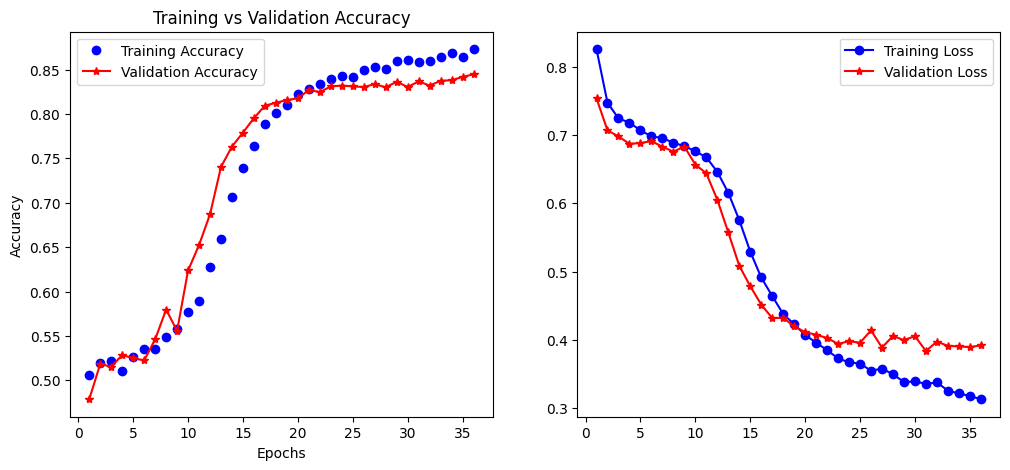

In [24]:
epochs = range(1, len(history.history['accuracy'])+1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report: ")
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Confusion Matrix: 
[[1097  254]
 [ 236 1413]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1351
           1       0.85      0.86      0.85      1649

    accuracy                           0.84      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.84      0.84      3000



# Training LSTM

In [29]:
model = Sequential([
    #Increased embedding
    Embedding(input_dim = max_words, output_dim = 300, input_length = max_sequences_length),
    #RNN layer with droput
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    #Added normalization for stability
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),
    LayerNormalization(),
    Dropout(0.3),
    #Extra dense layer
    Dense(64, activation='relu'),
    Dropout(0.2),
    #Binary Classification
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.5111 - loss: 0.8489 - val_accuracy: 0.5910 - val_loss: 0.6671
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.5607 - loss: 0.7151 - val_accuracy: 0.6413 - val_loss: 0.6391
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6131 - loss: 0.6602 - val_accuracy: 0.7100 - val_loss: 0.5903
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6571 - loss: 0.6187 - val_accuracy: 0.7510 - val_loss: 0.5277
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7087 - loss: 0.5609 - val_accuracy: 0.7793 - val_loss: 0.4828
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7607 - loss: 0.5007 - val_accuracy: 0.7967 - val_loss: 0.4478
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7795 - loss: 0.4655 - val_accuracy: 0.8077 - val_loss: 0.4251
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.8072 - loss: 0.4347 - val_accuracy: 0.8150 - val_loss: 0.4

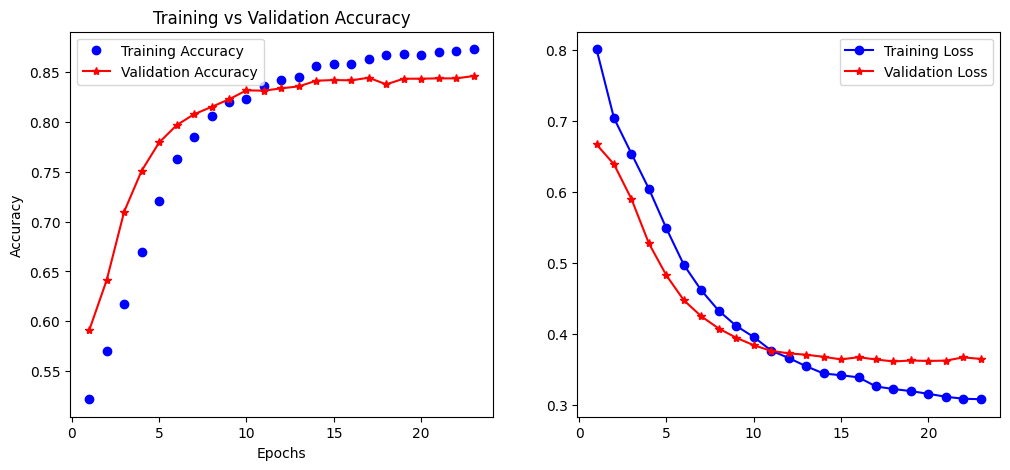

In [30]:
epochs = range(1, len(history.history['accuracy'])+1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.legend()
plt.show()

# GRU

In [31]:
model = Sequential([
    #Increased embedding
    Embedding(input_dim = max_words, output_dim = 300, input_length = max_sequences_length),
    #RNN layer with droput
    GRU(128, return_sequences=True, recurrent_dropout=0.2),
    #Added normalization for stability
    LayerNormalization(),
    Dropout(0.3),
    GRU(128, recurrent_dropout=0.2),
    LayerNormalization(),
    Dropout(0.3),
    #Extra dense layer
    Dense(64, activation='relu'),
    Dropout(0.2),
    #Binary Classification
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4984 - loss: 0.8554 - val_accuracy: 0.5543 - val_loss: 0.7070
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5558 - loss: 0.7441 - val_accuracy: 0.6040 - val_loss: 0.6622
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5897 - loss: 0.7031 - val_accuracy: 0.6193 - val_loss: 0.6414
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6017 - loss: 0.6813 - val_accuracy: 0.6390 - val_loss: 0.6216
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6235 - loss: 0.6533 - val_accuracy: 0.6567 - val_loss: 0.6073
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6520 - loss: 0.6334 - val_accuracy: 0.6690 - val_loss: 0.5925
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6660 - loss: 0.6122 - val_accuracy: 0.6907 - val_loss: 0.5782
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6879 - loss: 0.5851 - val_accuracy: 0.7033 - val_loss:

In [33]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report: ")
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step
Confusion Matrix: 
[[1108  243]
 [ 267 1382]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1351
           1       0.85      0.84      0.84      1649

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



# Detection System

In [41]:
def predict_sentiment(text, model, tokenizer, max_sequence_length = 100):
    text = clean_txt(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen = max_sequence_length)
    prediction = model.predict(padded_sequence)[0][0]

    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return sentiment, float(prediction)

txt = [
    "I love this product! Its great",
    "This is the worst product",
    "The movie was ok not great and not bad"
]
for t in txt:
    sentiment, confidence = predict_sentiment(t, model, tokenizer)
    print(f"Text: {t}\nPredicted Sentiment: {sentiment} {confidence : {confidence:.4f}}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: I love this product! Its great
Predicted Sentiment: Positive  0.96360290050506591796875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Text: This is the worst product
Predicted Sentiment: Negative  0.005787449888885021209716796875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Text: The movie was ok not great and not bad
Predicted Sentiment: Negative  0.2886035144329071044921875



In [45]:
model.save("lstm_model.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [47]:
import tensorflow as tf
print(tf.__version__)

2.18.0
